<a href="https://colab.research.google.com/github/KumudaBG/DeepLearning-Assignment3/blob/main/c3_tensorflow_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers

In [2]:
n  = 270
d = 3
x = tf.random.uniform((n, d), -1, 1)
x2 = tf.cast(x**2, tf.float32)
weights_true = tf.cast(tf.constant([[5,1,2],[2,2,1]]), tf.float32)
bias_true = tf.cast(tf.constant([2,1]), tf.float32)
y_true = tf.matmul(x2, weights_true, transpose_b=True) + tf.matmul(x,weights_true,transpose_b=True) + bias_true

print(f'y: {y_true.shape}')

y: (270, 2)


#Visualization

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

In [4]:
import plotly.graph_objects as pltgo
def plot_go_3d(x, y, y_pred=None):
  
  fig = pltgo.Figure()
  fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y.reshape([-1]),
                    name='y_true', mode='markers', marker=dict( size=10, color='dodgerblue', colorscale='Viridis', opacity=0.5)))
  if y_pred is not None:
    fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y_pred.reshape([-1]),
                   name='y_pred', mode='markers', marker=dict( size=10, color='goldenrod', colorscale='Viridis', opacity=0.5)))
  fig.update_layout(margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

In [5]:
X = TSNE(n_components=2).fit_transform(x)
Y = TSNE(n_components=1).fit_transform(y_true)
plot_go_3d(X,Y)

#Modelling

Linear layer

In [6]:

from tensorflow.keras.layers import Layer
class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

Dropout function

In [7]:
class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

Model with inbuilt Loss, Relu activation function

In [8]:
class MLP(Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(10)
        self.dropout = Dropout(0.5)
        self.linear_2 = Linear(8)
        self.dropout = Dropout(0.5)
        self.linear_3 = Linear(2)

    def call(self, inputs,training=None):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return self.linear_3(x)

SGD optimizer

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

dataset = tf.data.Dataset.from_tensor_slices((x, y_true))
dataset = dataset.shuffle(buffer_size=1).batch(30)

epochs = 1000
mlp = MLP()
for epoch in range(epochs):
    for step, (x_batch, y_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            y_pred_batch = mlp(x_batch,training=False)
            loss = mse_loss_fn(y_batch, y_pred_batch)
            loss += sum(mlp.losses)

        grads = tape.gradient(loss, mlp.trainable_weights)
        optimizer.apply_gradients(zip(grads, mlp.trainable_weights))

        loss_metric(loss)
    if epoch % 50 == 0:
      print(f'Epoch {epoch}, loss {loss_metric.result()}')

Epoch 0, loss 18.96080207824707
Epoch 50, loss 14.800589561462402
Epoch 100, loss 12.176709175109863
Epoch 150, loss 10.51513671875
Epoch 200, loss 9.437151908874512
Epoch 250, loss 8.409887313842773
Epoch 300, loss 7.369312286376953
Epoch 350, loss 6.539391994476318
Epoch 400, loss 5.900790214538574
Epoch 450, loss 5.394352912902832
Epoch 500, loss 4.982899188995361
Epoch 550, loss 4.641051769256592
Epoch 600, loss 4.351225852966309
Epoch 650, loss 4.101149082183838
Epoch 700, loss 3.8822460174560547
Epoch 750, loss 3.6886260509490967
Epoch 800, loss 3.5158541202545166
Epoch 850, loss 3.360809326171875
Epoch 900, loss 3.2210946083068848
Epoch 950, loss 3.0946855545043945


In [10]:
y_pred = mlp(x,training=False)

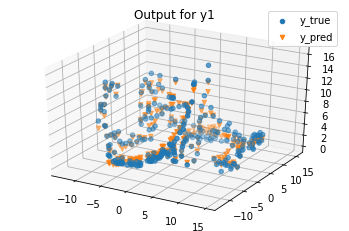

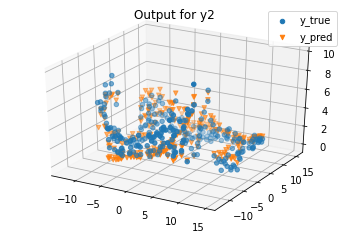

In [11]:

plot_3d('Output for y1', x, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2', x, y_true[:,1], y_pred[:,1])

In [12]:
X_plot = TSNE(n_components=2).fit_transform(x)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)